# High-level PyTorch Example

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm

In [2]:
class CocoDataSet():
    
    def __init__(self, dataType, cocoDir, maxImages=None):
        self.dataType = dataType
        self.cocoDir = cocoDir
        self.coco = COCO('{0}/annotations/instances_{1}.json'.format(cocoDir, dataType))
        self.imageIds = list(self.coco.imgs.keys())
        if maxImages and (maxImages < len(self.imageIds)):
            np.random.seed(0)
            self.imageIds = list(np.random.choice(a=self.imageIds, size=maxImages))
        print("Initialised with {} images".format(len(self.imageIds)))
        
    def createCategoryLabels(self):
        self.cats = self.coco.loadCats(self.coco.getCatIds())
        self.tags = sorted(set(categ['supercategory'] for categ in self.cats))
        self.labels_toidx = {l:i for i,l in enumerate(self.tags)}
        self.idx_tolabels = {i:l for i,l in enumerate(self.tags)}
        print("Labels to idx: ", self.labels_toidx)
        
    def loadData(self):
        self.y_data = np.zeros((len(self.imageIds), len(self.tags)), dtype=np.int32)
        self.x_data = np.zeros((len(self.imageIds), 224, 224, 3), dtype=np.float32)
        for idx, imgId in enumerate(tqdm(self.imageIds)):
            # Targets
            targets = np.zeros(len(self.tags))
            for scat in self._getSuperCats(imgId):
                targets[self.labels_toidx[scat]] = 1
            self.y_data[idx] = targets
            # Image (channel-last)
            I = Image.open('%s/images/%s/%012d.jpg' % (self.cocoDir, self.dataType, imgId)).convert('RGB')
            img_array = np.array(ImageOps.fit(I, (224, 224), Image.ANTIALIAS))
            self.x_data[idx] = img_array
            
    def prepareData(self, channel_first=True, train_split=0.9, shuffle=True):
        # Scale pixel intensity
        self.x_data = self.x_data/255.0
        # Channel-first
        if channel_first:
            self.x_data = np.swapaxes(self.x_data, 1, 3)
        # Shuffle data
        if shuffle:
            self._shuffleData()
        # Train_test split
        train_idx = int(train_split*len(self.x_data))
        print("Train/test split-index: ", train_idx)
        self.y_train, self.y_test = self.y_data[:train_idx], self.y_data[train_idx:]
        del self.y_data
        self.x_train, self.x_test = self.x_data[:train_idx], self.x_data[train_idx:]
        del self.x_data
        
    def _shuffleData(self):
        np.random.seed(0)
        s = np.arange(len(self.x_data))
        np.random.shuffle(s)
        self.x_data = self.x_data[s]
        self.y_data = self.y_data[s]
            
    def _getSuperCats(self, imgId):
        idToSuper = {categ['id']: categ['supercategory'] for categ in self.cats}
        return list(set([idToSuper[obj['category_id']] for obj in self.coco.imgToAnns[imgId]]))  

In [3]:
coco_data = CocoDataSet(dataType='train2017', cocoDir='/data', maxImages=40000)
coco_data.createCategoryLabels()
coco_data.loadData()
coco_data.prepareData()

loading annotations into memory...
Done (t=18.03s)
creating index...


  0%|          | 0/40000 [00:00<?, ?it/s]

index created!
Initialised with 40000 images
Labels to idx:  {'outdoor': 8, 'appliance': 2, 'furniture': 5, 'electronic': 3, 'accessory': 0, 'kitchen': 7, 'sports': 10, 'vehicle': 11, 'food': 4, 'animal': 1, 'person': 9, 'indoor': 6}


100%|██████████| 40000/40000 [40:47<00:00, 16.34it/s]


Train/test split-index:  36000


In [73]:
import os
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn.init as init
from torch.autograd import Variable
from sklearn.metrics import hamming_loss
from common.params import *
from common.utils import *

In [5]:
N_CLASSES = len(coco_data.tags)
print(N_CLASSES)
EPOCHS = 15

12


In [6]:
# Big impact on training-time (from 350 to 165s)
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [7]:
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("GPU: ", get_gpu_name())

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_4
Numpy:  1.13.3
GPU:  ['Tesla K80']


In [8]:
class SymbolModule(nn.Module):
    def __init__(self):
        super(SymbolModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
        # feature map size is 56*56 by pooling
        self.fc1 = nn.Linear(100*56*56, 512)
        self.fc2 = nn.Linear(512, N_CLASSES)

    def forward(self, x):
        """ PyTorch requires a flag for training in dropout """
        x = self.conv2(F.relu(self.conv1(x)))
        x = F.relu(F.max_pool2d(x, kernel_size=2, stride=2))
        x = F.dropout(x, 0.25, training=self.training)

        x = self.conv4(F.relu(self.conv3(x)))
        x = F.relu(F.max_pool2d(x, kernel_size=2, stride=2))
        x = F.dropout(x, 0.25, training=self.training)

        x = x.view(-1, 100*56*56)   # reshape Variable
        x = F.dropout(F.relu(self.fc1(x)), 0.5, training=self.training)
        return self.fc2(x)

In [9]:
def init_model(m):
    opt = optim.SGD(m.parameters(), lr=LR, momentum=MOMENTUM)
    criterion = nn.BCEWithLogitsLoss()
    return opt, criterion

In [10]:
%%time
# Data into format for library
x_train, x_test, y_train, y_test = coco_data.x_train, coco_data.x_test, coco_data.y_train, coco_data.y_test
# Torch-specific
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

(36000, 3, 224, 224) (4000, 3, 224, 224) (36000, 12) (4000, 12)
float32 float32 float32 float32
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.82 ms


In [11]:
%%time
sym = SymbolModule()
sym.cuda()

CPU times: user 3.2 s, sys: 788 ms, total: 3.99 s
Wall time: 4.03 s


In [12]:
%%time
optimizer, criterion = init_model(sym)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 230 µs


In [13]:
%%time
# Sets training = True
sym.train()  
for j in range(EPOCHS):
    for data, target in yield_mb(x_train, y_train, BATCHSIZE, shuffle=True):
        # Get samples
        data = Variable(torch.FloatTensor(data).cuda())
        target = Variable(torch.FloatTensor(target).cuda())
        # Init
        optimizer.zero_grad()
        # Forwards
        output = sym(data)
        # Loss
        loss = criterion(output, target)
        # Back-prop
        loss.backward()
        optimizer.step()
    # Log
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
CPU times: user 1h 43min 24s, sys: 50min, total: 2h 33min 25s
Wall time: 2h 33min 41s


In [14]:
%%time
# Test model
# Sets training = False
sym.eval()
# Calculate probability of each class seperately
m = nn.Sigmoid()

n_samples = (y_test.shape[0]//BATCHSIZE)*BATCHSIZE
y_guess = np.zeros((n_samples, N_CLASSES), dtype=np.float32)
y_truth = y_test[:n_samples]
c = 0
for data, target in yield_mb(x_test, y_test, BATCHSIZE):
    # Get samples
    data = Variable(torch.FloatTensor(data).cuda())
    # Forwards
    output = m(sym(data))
    pred = output.data.cpu().numpy()
    # Collect results
    y_guess[c*BATCHSIZE:(c+1)*BATCHSIZE] = pred
    c += 1

CPU times: user 23 s, sys: 5.81 s, total: 28.8 s
Wall time: 28.8 s


In [96]:
# Hamming loss is the fraction of labels that are incorrectly predicted
hamming_loss(y_truth, (y_guess>0.5))

0.14476226478494625

Truth:  ['person', 'sports']
Guess:  ['person', 'sports']


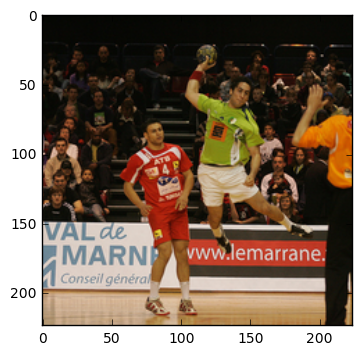

In [97]:
NUM = 1000
# Example
# True
print("Truth: ", [coco_data.idx_tolabels[idx] for idx in list(np.where((y_truth[NUM] == 1) == True)[0])])
# Guess
print("Guess: ", [coco_data.idx_tolabels[idx] for idx in list(np.where((y_guess[NUM] > 0.5) == True)[0])])
# Show image
img = Image.fromarray(np.array(np.swapaxes(x_test[NUM]*255, 0, -1), dtype=np.uint8), mode='RGB')
plt.imshow(img)